In [ ]:
import os

try:
    import nucleotide_transformer
except:
    !pip install numpy==1.23.5
    !pip install git+https://github.com/instadeepai/nucleotide-transformer@main |tail -n 1
    import nucleotide_transformer

if "COLAB_TPU_ADDR" in os.environ:
    from jax.tools import colab_tpu

    colab_tpu.setup_tpu()

!pip install lightgbm

import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model

  Running command git clone --filter=blob:none --quiet https://github.com/instadeepai/nucleotide-transformer /tmp/pip-req-build-mjoxmr28


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/C_edit.csv")
df.head()

,sequence,edit_positions
0,TGTAGTTTCCGCCGCGTTTATGGCCGCGTTAAGTCTGAGTGCCGCT...,"[1481, 1547, 5044, 5057, 151013, 152476, 17046..."
1,CAAAGCCACCCTGGGTCACCTACATACTAAGGGAATAAACGCCACT...,[425]
2,ACTGTGGCTCCCGAAGCTGCTTCGGGCCCCAGCGGTGAGGAAGAAG...,"[529, 8621, 8648, 8658, 22156, 33299, 44351, 7..."
3,AGAATTTCGTCAAAGTCTGGTCCGACGTAACCCTCTCGGGAAATCC...,"[16072, 26659]"
4,AAAATCTTATAAGTAGTTTCGAAATAAATATTAACAAGGTTTGACC...,"[5045, 5164]"


In [ ]:
#@title Select a model
#@markdown ---
model_name = '500M_1000G'#@param['500M_human_ref', '500M_1000G', '2B5_1000G', '2B5_multi_species', '50M_multi_species_v2', '100M_multi_species_v2', '250M_multi_species_v2', '500M_multi_species_v2']
#@markdown ---

In [ ]:
embeddings_layer = 20  # layer of embeddings extraction (0:24)
seq_max_length = 996 # must be <= 1000, 996 is also dividable by 6

# Get pretrained model
parameters, forward_fn, tokenizer, config = get_pretrained_model(
    model_name=model_name,
    embeddings_layers_to_save=(embeddings_layer,),
    max_positions = seq_max_length
)
forward_fn = hk.transform(forward_fn)

checkpoints/500M_1000G/hyperparams.json


/root/.cache/nucleotide_transformer/500M_1000G/hyperparams.json: 100%|██████████| 820/820 [00:00<00:00, 2.60kB/s]
/root/.cache/nucleotide_transformer/500M_1000G/ckpt.joblib: 100%|██████████| 1.94G/1.94G [00:40<00:00, 48.3MB/s]


# Retrieving embeddings

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle

# Every sequence has at least one edited C
with open('/content/drive/My Drive/data/transformer_cedit_sequences2.pkl', 'rb') as f:
    sequences = pickle.load(f)

with open('/content/drive/My Drive/data/transformer_cedit_token_classes2.pkl', 'rb') as f:
    sequence_tokens_class = pickle.load(f)

In [ ]:
sequences = sequences[:3000]
sequence_tokens_class = sequence_tokens_class[:3000]

In [ ]:
import random
import numpy as np

batch_size = 8 # Adjust to available memory

embeddings = []  # Stores 6mers embeddings
embeddings_labels = []  # stores labels of 6mers embeddings

# Split sequences into batches
batched_sequences = [sequences[i:i + batch_size] for i in range(0, len(sequences), batch_size)]
batched_token_classes = [sequence_tokens_class[i:i + batch_size] for i in range(0, len(sequence_tokens_class), batch_size)]

random_key = jax.random.PRNGKey(0)
extraction_layer = "embeddings_" + str(embeddings_layer)
cls_token_position = 0 # Position of the CLS token for every sequence

for batch, batch_token_classes in zip(batched_sequences, batched_token_classes):
    # Tokenize the batch
    tokens_ids = [b[1] for b in tokenizer.batch_tokenize(batch)]
    tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)

    token_classes = [] # list of classes of all embeddings in the batch
    for item in batch_token_classes:
        token_classes += item

    # Infer
    outs = forward_fn.apply(parameters, random_key, tokens)

    # Get embeddings
    batch_embeddings = outs[extraction_layer]

    # Mask for padding tokens
    padding_mask = (tokens != tokenizer.pad_token_id) & (jnp.arange(tokens.shape[1]) != cls_token_position)

    # Element-wise multiplication to set embeddings corresponding to padding tokens to zero
    masked_embeddings = batch_embeddings * padding_mask[:, :, None]

    # Removing embeddings relative to CLS and padding tokens
    sum_embeddings = jnp.sum(masked_embeddings, axis=-1)
    non_zero_mask = sum_embeddings != 0.0
    non_zero_embeddings = masked_embeddings[non_zero_mask]

    # Removing embeddings labeled as 2
    indices_to_remove = [i for i in range(len(token_classes)) if token_classes[i] == 2]
    non_zero_embeddings = np.delete(non_zero_embeddings, indices_to_remove, axis = 0)
    token_classes = np.delete(token_classes, indices_to_remove)

    embeddings.append(non_zero_embeddings)
    embeddings_labels.append(token_classes)

X = jnp.concatenate(embeddings, axis=0)
y = jnp.concatenate(embeddings_labels, axis=0)

In [ ]:
if len(X) == len(y):
    print(True)
    print(len(X))
else:
    print(False)

True
341145


In [ ]:
import pickle

with open('/content/drive/My Drive/data/transformer_X6.pkl', 'wb') as f: # Storing embeddings
  pickle.dump(X, f)

with open('/content/drive/My Drive/data/transformer_y6.pkl', 'wb') as f: # Storing labels
  pickle.dump(y, f)

## Downstream

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
# Loading data from drive
with open('/content/drive/My Drive/data/transformer_X4.pkl', 'rb') as f:
    X = pickle.load(f)


with open('/content/drive/My Drive/data/transformer_y4.pkl', 'rb') as f:
    y = pickle.load(f)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate the RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)

# Fit and transform the training data
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [ ]:
!pip install lightgbm

import lightgbm as lgb
from sklearn.metrics import accuracy_score


params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

clf = lgb.LGBMClassifier(**params)


clf.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 30040, number of negative: 30040
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.769719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326400
[LightGBM] [Info] Number of data points in the train set: 60080, number of used features: 1280
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(feature_fraction=0.9, learning_rate=0.05, metric='binary_error',
               objective='binary')

In [ ]:
import random
import numpy as np

sequences = sequences[:800]
sequence_tokens_class = sequence_tokens_class[:800]

batch_size = 8 # Adjust to available memory

embeddings = []  # Stores 6mers embeddings
embeddings_labels = []  # stores labels of 6mers embeddings

# Split sequences into batches
batched_sequences = [sequences[i:i + batch_size] for i in range(0, len(sequences), batch_size)]
batched_token_classes = [sequence_tokens_class[i:i + batch_size] for i in range(0, len(sequence_tokens_class), batch_size)]

random_key = jax.random.PRNGKey(0)
extraction_layer = "embeddings_" + str(embeddings_layer)
cls_token_position = 0 # Position of the CLS token for every sequence

for batch, batch_token_classes in zip(batched_sequences, batched_token_classes):
    # Tokenize the batch
    tokens_ids = [b[1] for b in tokenizer.batch_tokenize(batch)]
    tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)

    token_classes = [] # list of classes of all embeddings in the batch
    for item in batch_token_classes:
        token_classes += item

    # Infer
    outs = forward_fn.apply(parameters, random_key, tokens)

    # Get embeddings
    batch_embeddings = outs[extraction_layer]

    # Mask for padding tokens
    padding_mask = (tokens != tokenizer.pad_token_id) & (jnp.arange(tokens.shape[1]) != cls_token_position)

    # Element-wise multiplication to set embeddings corresponding to padding tokens to zero
    masked_embeddings = batch_embeddings * padding_mask[:, :, None]

    # Removing embeddings relative to CLS and padding tokens
    sum_embeddings = jnp.sum(masked_embeddings, axis=-1)
    non_zero_mask = sum_embeddings != 0.0
    non_zero_embeddings = masked_embeddings[non_zero_mask]

    # Removing embeddings labeled as 2
    indices_to_remove = [i for i in range(len(token_classes)) if token_classes[i] == 2 or i in range(8) or i in range(len(token_classes)-8, len(token_classes))]
    non_zero_embeddings = np.delete(non_zero_embeddings, indices_to_remove, axis = 0)
    token_classes = np.delete(token_classes, indices_to_remove)

    embeddings.append(non_zero_embeddings)
    embeddings_labels.append(token_classes)

X_test = jnp.concatenate(embeddings, axis=0)
y_test = jnp.concatenate(embeddings_labels, axis=0)

In [ ]:
X_test = jnp.concatenate(embeddings, axis=0)
y_test = jnp.concatenate(embeddings_labels, axis=0)

In [ ]:
len(X_test)

77138

In [ ]:
y_pred = clf.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Accuracy: 0.97


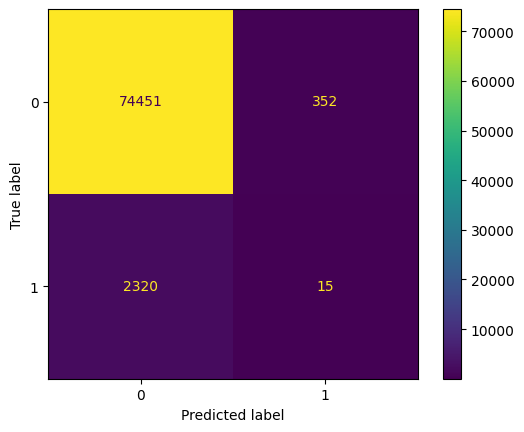

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred, labels= [0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


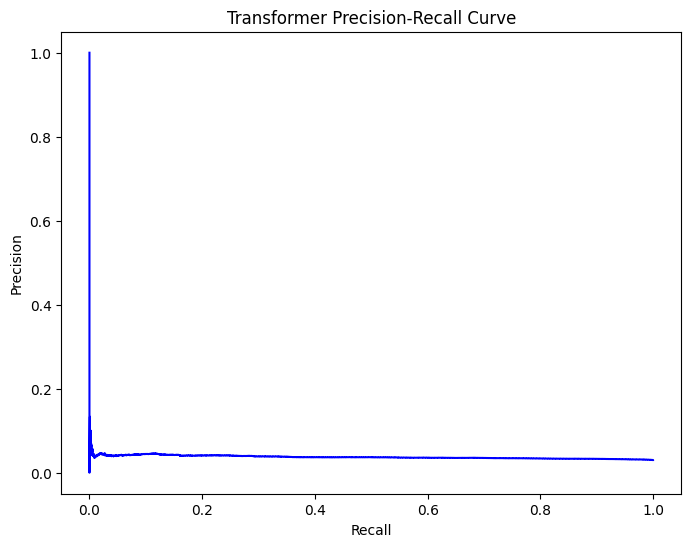

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Transformer Precision-Recall Curve')
plt.show()

In [ ]:
with open('/content/drive/My Drive/data/transformer_recall_precision10.pkl', 'wb') as f:
  pickle.dump([recall, precision], f)